<a href="https://colab.research.google.com/github/bgtripp/COVID-19-Project/blob/master/COVID_19_Project_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd

regionData = pd.read_csv('https://raw.githubusercontent.com/bgtripp/COVID-19-Project/master/covid_19_data.csv')
regionData.head()

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


In [0]:
confirmedData = pd.read_csv('https://raw.githubusercontent.com/bgtripp/COVID-19-Project/master/time_series_covid_19_confirmed.csv')
confirmedData.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,4,4,5,7,7,7,11,16,21,22,22,22,24,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,10,12,23,33,38,42,51,55,59,64,70,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,3,5,12,12,17,17,19,20,20,20,24,26,37,48,54,60,74,87,90,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,39,39,53,75,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,3,3,3,4,4,5,7,7


In [0]:
deathsData = pd.read_csv('https://raw.githubusercontent.com/bgtripp/COVID-19-Project/master/time_series_covid_19_deaths.csv')
deathsData.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,4,4,4,4,4
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,2,2,2,2,2,4,5,5,6,8,10,10,11
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,3,4,4,4,7,9,11,15,17,17,19,21,25,26,29,31,35
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,3,3,3,6,8
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2


In [0]:
recoveredData = pd.read_csv('https://raw.githubusercontent.com/bgtripp/COVID-19-Project/master/time_series_covid_19_recovered.csv')
recoveredData.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,2,2,2,2,2,2
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,2,10,17,17,31,31,33,44
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,8,12,12,12,12,12,32,32,32,65,65,24,65,29,29,31,31,37
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,10
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
totDeaths = deathsData.iloc[:, -1].sum()
totRecovered = recoveredData.iloc[:, -1].sum()

mortalityRate = totDeaths/(totDeaths+totRecovered)

print(mortalityRate)

0.18591329125195402


Well that's concerningly high. A couple weeks ago when I ran this it was only about 6%. Maybe we have more data on people who died than who recovered, because it's more obvious and pressing when someone dies. Also, people are much more likely to be tested to begin with if their symptoms are serious.

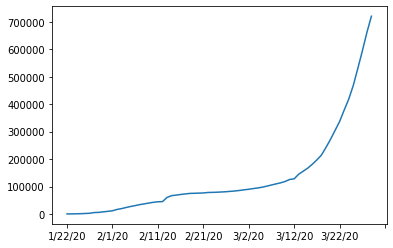

In [0]:
totConfirmed = confirmedData.iloc[:, 4:-1].sum() 
totConfirmed.plot() #This is a series now


This doesn't look quite like exponential growth, but I'm glad it's under what exponential growth should look like considering the many cases that have not yet been tested.

(Note: I made this comment a couple weeks ago when it looked like a weird curvy line. Towards the end now, it's starting to look pretty exponential.)

South Korea reportedly has the highest testing rate, so let's see if there's a better fit there.

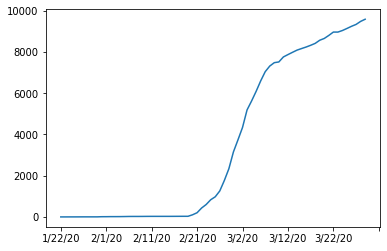

In [0]:
southKorea = confirmedData.loc[confirmedData['Country/Region'] == 'Korea, South'] #It took me a while to figure out that in this csv only it's "Korea, South" instead of South Korea
skTotConfirmed = southKorea.iloc[0, 4:-1] #Again it's a series now
skTotConfirmed.plot()

Oooh. Now this looks much more like it. We're even starting to get the logistic function at the end.

Let's try fitting it.

Fit logistic curve: 8837.85/[1+e^(-0.28x+11.37)]


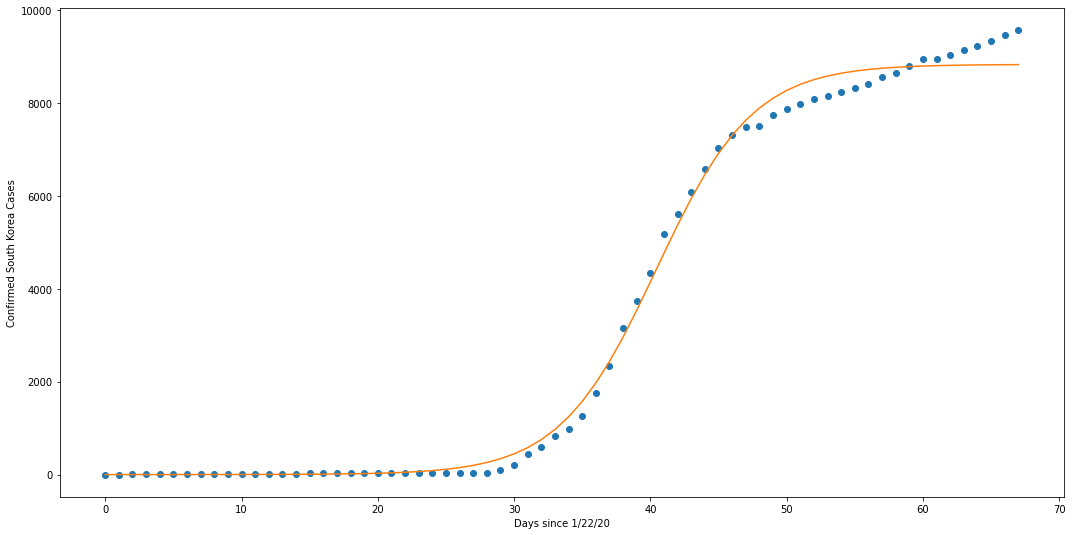

In [0]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

def f(x, a, b, c):
  return a / (1 + np.exp(-b*(x-c)))


y1 = skTotConfirmed.to_numpy()
x1 = np.arange(len(y1))

(a1, b1, c1), pcov = opt.curve_fit(f, x1, y1)

y_fit1 = f(x1, a1, b1, c1)

xsize = 18
ysize = 9

fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

ax.plot(x1, y1, 'o')
ax.plot(x1, y_fit1, '-')

plt.ylabel('Confirmed South Korea Cases')
plt.xlabel('Days since 1/22/20')

print('Fit logistic curve: '+str(round(a1, 2))+'/[1+e^('+str(round(-b1, 2))+'x+'+str(round(b1*c1, 2))+')]')

I can now use this simple model to estimate the future rate of cases. For example, let's predict how many cases there will be on April 1st, 68 days after Jan 22nd.

In [0]:
int(f(68, a1, b1, c1))

8834

Unfortunately, now that I've updated the data more recently (being march 24th) the number of cases seems to be increasing past the logistic curve again.

Now let's try the same thing with Italy, one of the hubs of the pandemic.

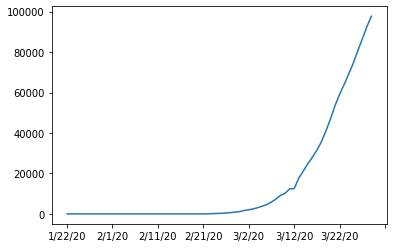

In [0]:
italy = confirmedData.loc[confirmedData['Country/Region'] == 'Italy']
itTotConfirmed = italy.iloc[0, 4:-1] #Again it's a series now
itTotConfirmed.plot()

This looks more purely exponential. Not much of a sign of slowing.

Again, let's fit it, but this time as an exponential function.

Fit logistic curve: 127168.3/[1+e^(-0.19x+11.43)]


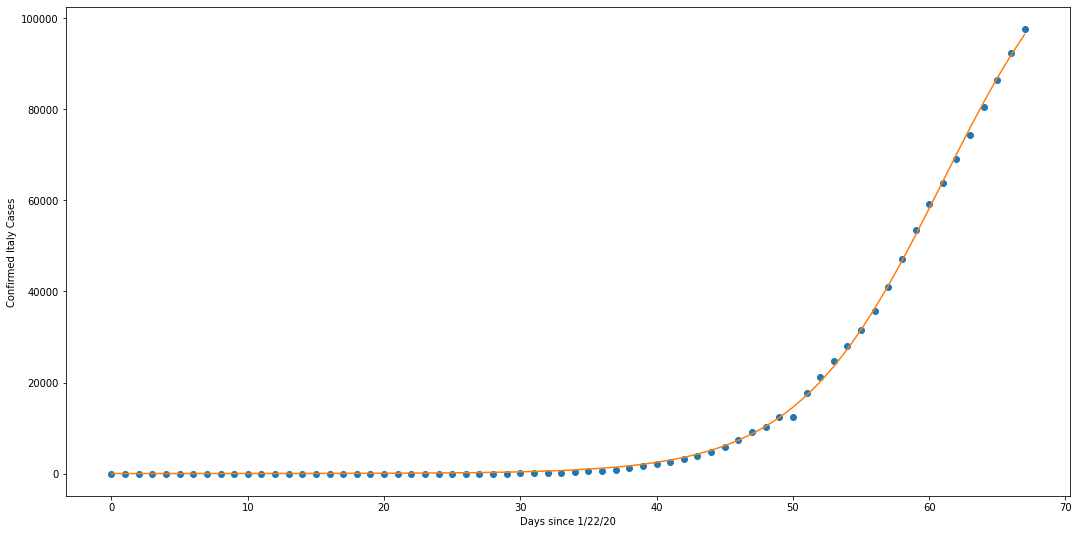

In [0]:
y2 = itTotConfirmed.to_numpy()
x2 = np.arange(len(y2))

(a2, b2, c2), pcov = opt.curve_fit(f, x2, y2)

y_fit2 = f(x2, a2, b2, c2)

fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

ax.plot(x2, y2, 'o')
ax.plot(x2, y_fit2, '-')

plt.ylabel('Confirmed Italy Cases')
plt.xlabel('Days since 1/22/20')

print('Fit logistic curve: '+str(round(a2, 2))+'/[1+e^('+str(round(-b2, 2))+'x+'+str(round(b2*c2, 2))+')]')

Now let's again try to predict April 1st cases:

In [0]:
int(f(68, a2, b2, c2))

100609

Yeesh. Really shows you how quickly the virus can go from a distant worry to a very real crisis!

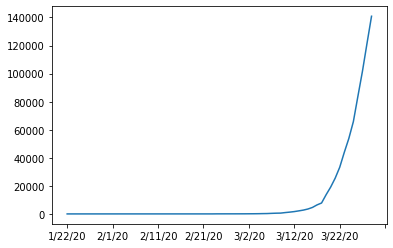

In [0]:
usa = confirmedData.loc[confirmedData['Country/Region'] == 'US']
usTotConfirmed = usa.iloc[0, 4:-1] #Again it's a series now
usTotConfirmed.plot()

The testing is pretty far behind in the US, so it will be harder to paint an accurate picture. Regardless, we're definitely in the exponential stage.

Fit logistic curve: 252626.02/[1+e^(-0.31x+20.4)]


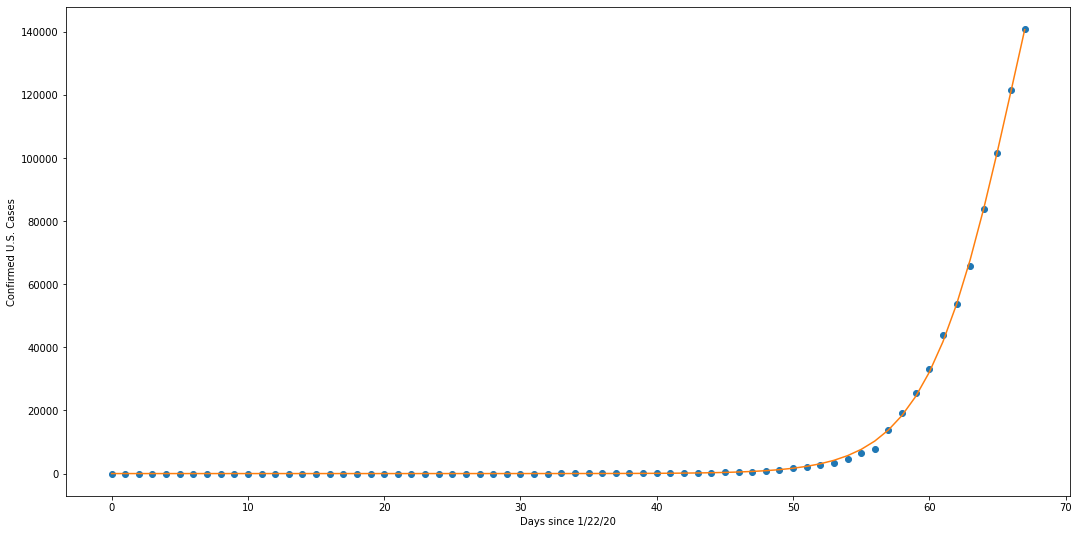

In [0]:
y3 = usTotConfirmed.to_numpy()
x3 = np.arange(len(y3))

(a3, b3, c3), pcov = opt.curve_fit(f, x3, y3)

y_fit3 = f(x3, a3, b3, c3)

fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

ax.plot(x3, y3, 'o')
ax.plot(x3, y_fit3, '-')

plt.ylabel('Confirmed U.S. Cases')
plt.xlabel('Days since 1/22/20')

print('Fit logistic curve: '+str(round(a3, 2))+'/[1+e^('+str(round(-b3, 2))+'x+'+str(round(b3*c3, 2))+')]')

That worked better than I expected. Now let's do another prediction for April 1st:

In [0]:
int(f(68, a3, b3, c3))

159321

Ooh. Scary. If anything, this number should be an underestimate due to the lack of adequate testing thus far.

Let's put these all on one nice looking graph.

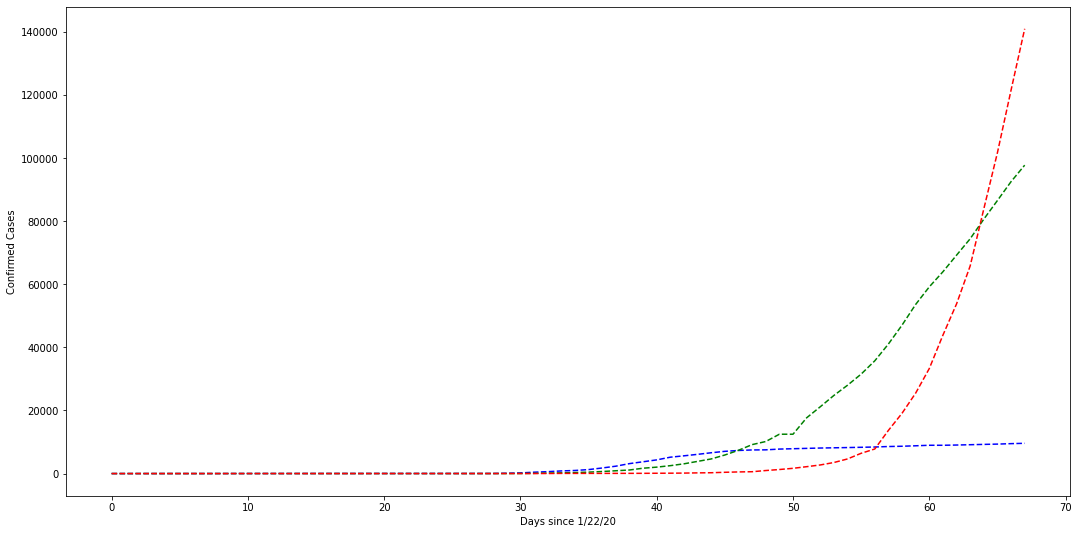

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

ax.plot(x1, y1, '--', color='b')

ax.plot(x2, y2, '--', color='g')

ax.plot(x3, y3, '--', color='r')

plt.ylabel('Confirmed Cases')
plt.xlabel('Days since 1/22/20')

lines = ax.get_lines()
lines[0].set_label('South Korea')
lines[1].set_label('Italy')
lines[2].set_label('United States')


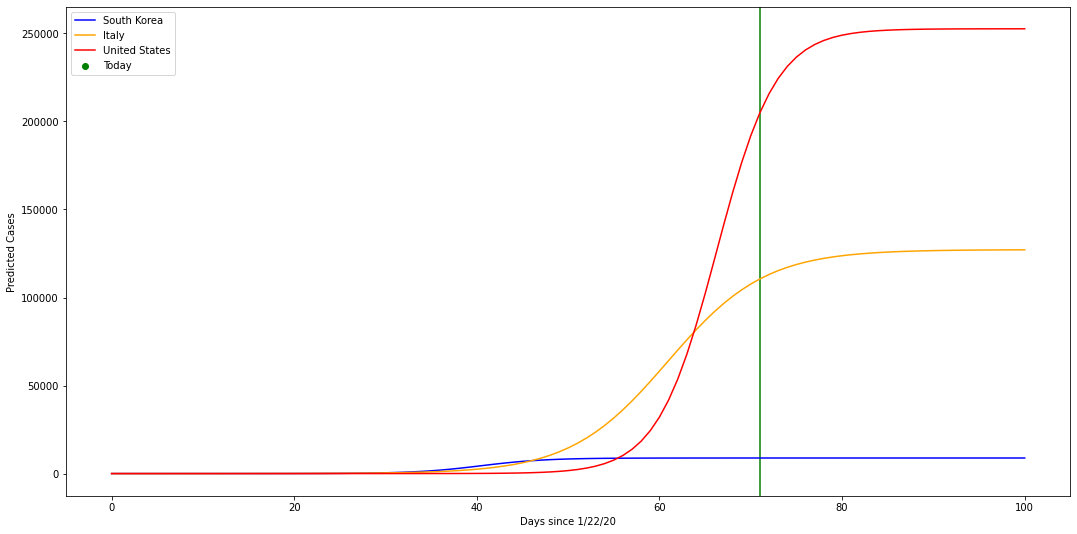

In [0]:
from datetime import date

today = date.today()
todayInt = (today-date(2020, 1, 22)).days


fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

x_future = np.arange(101)

pred1 = f(x_future, a1, b1, c1)
pred2 = f(x_future, a2, b2, c2)
pred3 = f(x_future, a3, b3, c3)

ax.plot(x_future, pred1, '-', color='b')

ax.plot(x_future, pred2, '-', color='orange')

ax.plot(x_future, pred3, '-', color='r')

ax.scatter(todayInt, 0, marker='|', color='g', s=20**6)
ax.scatter(None, None, color='g', label='Today')

plt.ylabel('Predicted Cases')
plt.xlabel('Days since 1/22/20')
#plt.yscale('log')

lines = ax.get_lines()
lines[0].set_label('South Korea')
lines[1].set_label('Italy')
lines[2].set_label('United States')
ax.legend()

The US is predicted to take a drastic lead here pretty soon. (Note: I said that a couple weeks ago, and it ended up happening!) 

My regression thinks that we're past the inflection points for all of these curves, which I think is generous, but I'll take it.

Now let's try both of these graphs scaled to the countries' respective populations.

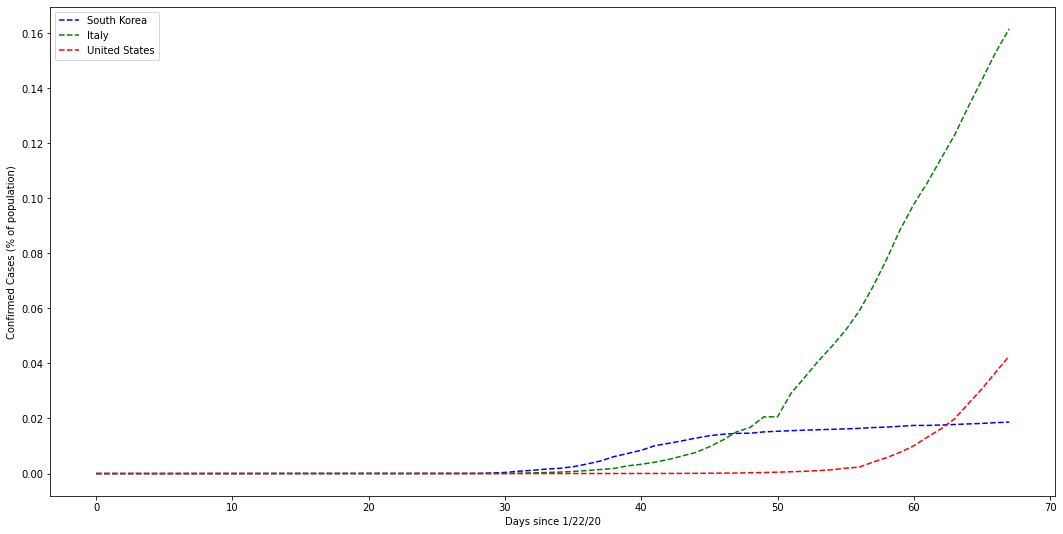

In [0]:
#Populations from Worldometer, 3/27/20

skPop = 51257828
itPop = 60484649
usPop = 330500143

fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

ax.plot(x1, y1/skPop*100, '--', color='b')

ax.plot(x2, y2/itPop*100, '--', color='g')

ax.plot(x3, y3/usPop*100, '--', color='r')

plt.ylabel('Confirmed Cases (% of population)')
plt.xlabel('Days since 1/22/20')

lines = ax.get_lines()
lines[0].set_label('South Korea')
lines[1].set_label('Italy')
lines[2].set_label('United States')

ax.legend()

When scaled to population, the severity of the situation in Italy really becomes clear.

Let's also scale the predicted values like this.

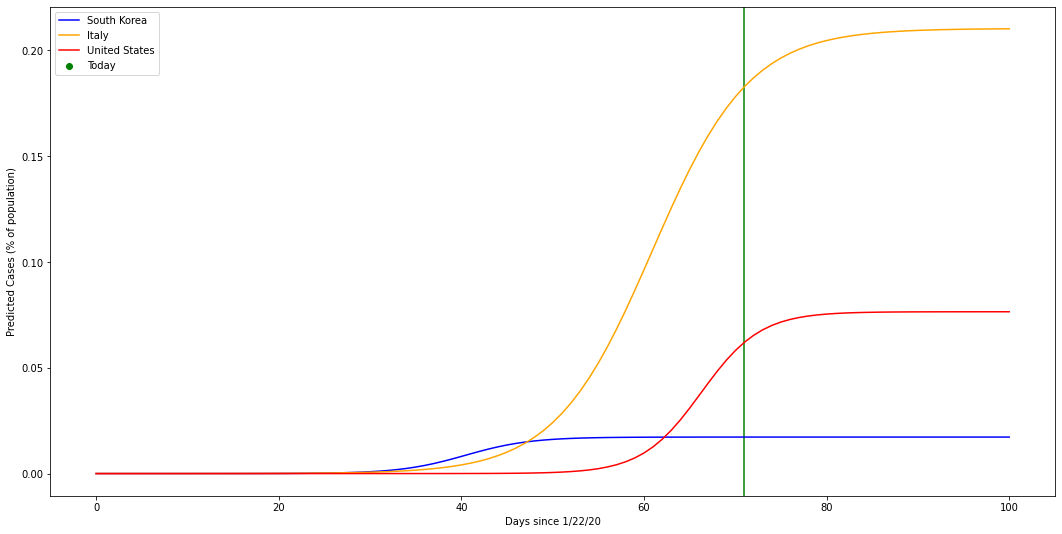

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

x_future = np.arange(101)

pred1 = f(x_future, a1, b1, c1)
pred2 = f(x_future, a2, b2, c2)
pred3 = f(x_future, a3, b3, c3)

ax.plot(x_future, pred1/skPop*100, '-', color='b')

ax.plot(x_future, pred2/itPop*100, '-', color='orange')

ax.plot(x_future, pred3/usPop*100, '-', color='r')

ax.scatter(todayInt, 0, marker='|', color='g', s=20**6)
ax.scatter(None, None, color='g', label='Today')

plt.ylabel('Predicted Cases (% of population)')
plt.xlabel('Days since 1/22/20')
#plt.yscale('log')

lines = ax.get_lines()
lines[0].set_label('South Korea')
lines[1].set_label('Italy')
lines[2].set_label('United States')


ax.legend()

When scaled for the population, Italy seems to be in the worst situation here.  

In [0]:
usDeaths = deathsData.loc[deathsData['Country/Region'] == 'US'].iloc[:, -1]
usRecovered = recoveredData.loc[recoveredData['Country/Region'] == 'US'].iloc[:, -1]

usMortality = usDeaths/(usDeaths+usRecovered)
usMortality

225    0.345395
Name: 3/30/20, dtype: float64

Again, this is much higher than the WHO estimated mortality rate of around 3%. The limited testing in the US would certainly prioritize those with more severe symptoms, so it's likely that our data is skewed towards people who have serious cases.

Finally, let's try to make a prediction for the most relevant region to myself, San Francisco:

In [0]:
nytData = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv')
sfData = nytData.loc[nytData['county'] == 'San Francisco']
sfData.head()

,date,county,state,fips,cases,deaths
49,2020-02-02,San Francisco,California,6075.0,2,0
57,2020-02-03,San Francisco,California,6075.0,2,0
65,2020-02-04,San Francisco,California,6075.0,2,0
73,2020-02-05,San Francisco,California,6075.0,2,0
82,2020-02-06,San Francisco,California,6075.0,2,0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


Fit logistic curve: -659.87/[1+e^(0.23x+-12.82)]


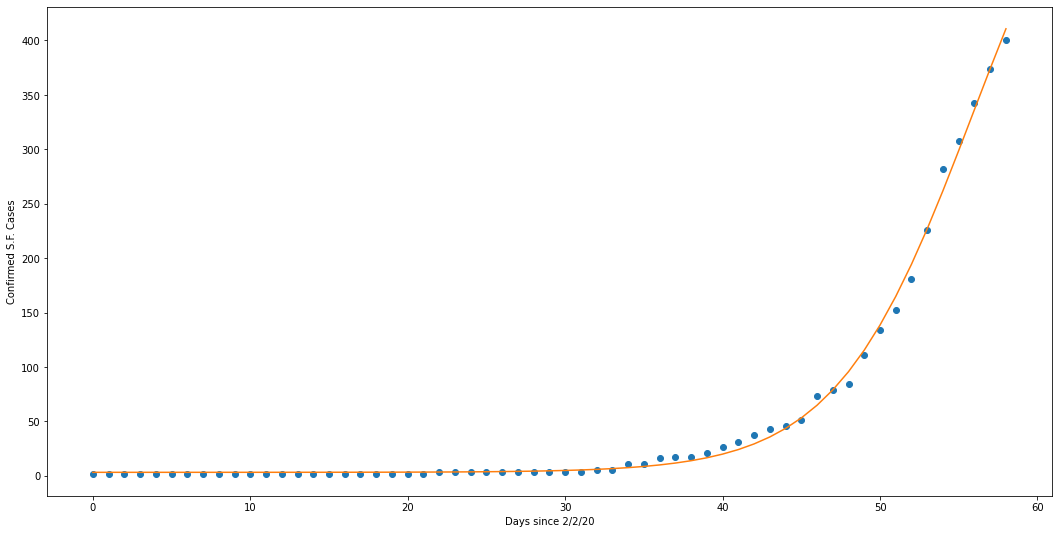

In [0]:
def f2(x, a, b, c, d):
  return a / (1 + np.exp(-b*(x-c))) + d

x4 = np.arange(len(sfData.index))
y4 = sfData['cases']


(a4, b4, c4, d), pcov = opt.curve_fit(f2, x4, y4)

y_fit4 = f2(x4, a4, b4, c4, d)

fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

ax.plot(x4, y4, 'o')
ax.plot(x4, y_fit4, '-')

plt.ylabel('Confirmed S.F. Cases')
plt.xlabel('Days since 2/2/20')

print('Fit logistic curve: '+str(round(a4, 2))+'/[1+e^('+str(round(-b4, 2))+'x+'+str(round(b4*c4, 2))+')]')


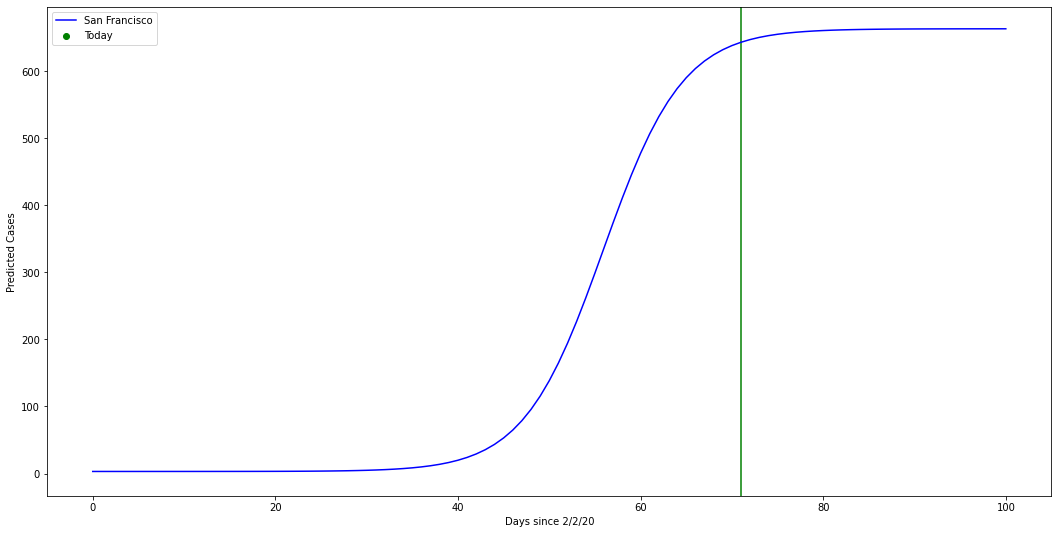

In [0]:
fig, ax = plt.subplots(1, 1, figsize=(xsize, ysize))

x_future = np.arange(101)

ax.plot(x_future, f2(x_future, a4, b4, c4, d), '-', color='b')

ax.scatter(todayInt, 0, marker='|', color='g', s=20**6)
ax.scatter(None, None, color='g', label='Today')

plt.ylabel('Predicted Cases')
plt.xlabel('Days since 2/2/20')
#plt.yscale('log')

lines = ax.get_lines()
lines[0].set_label('San Francisco')

ax.legend()

Interestingly, my regression seems to predict that San Francisco is already past the inflection point. Maybe this whole shelter-in-place thing is working, or maybe our testing isn't keeping up. Also, it's likely that once we relax our policies another curve will start up again. For now, let's hope this regression is correct.

---

